# Tree Model with Spotify popularity of a new song

## Problem Definition



This project will take data features collected for songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 & 2021. **The popularity of the song will be predicted using a tree-based regression model trained on these features.**

**Minimize the cross-validated root mean squared error ( RMSE ) when predicting the popularity of a new song.**

Determine the importance of the features in driving the regression result. The project should be done using tree-based regression techniques as covered in class. The parameters of the trees should be carefully selected to avoid over-fitting.

 This is  a categorical supervised classification problem since I am looking at popularity as the target. This project will use a regression model consistent with what is best suited for it's data.


##Challenges
There are two main challenges for this project:

Choosing appropriate predictors. When building a machine learning model, we want to make sure that we consider how the model will be ultimately used. For this project, we are predicting the popularity of a new song. Therefore, we should only include the predictors we would have for a new song.

Data cleaning and feature engineering. Some creative cleaning and/or feature engineering may be needed to extract useful information for prediction.

## Data Collection/Sources


### Data Overview

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error


import seaborn as sns
import pickle

import graphviz
from IPython.display import display
from sklearn import tree

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import json

### File Paths

### Load Data

In [2]:
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv"
!curl -s -I {url}

HTTP/1.1 200 OK
x-amz-id-2: ThzHyNHBNxgJJJJnLcZySS33cUKKzHibPMbTsSiPwpa5dIypi2lhT3ci6uUDqVLSKLsyrSGzSWs=
x-amz-request-id: ME61M4ZPW1FT9ZRS
Date: Sun, 07 Jul 2024 19:28:38 GMT
Last-Modified: Wed, 04 Oct 2023 17:23:56 GMT
ETag: "65b9875b11e0d7ea03ee2af024f45e99"
x-amz-server-side-encryption: AES256
Accept-Ranges: bytes
Content-Type: text/csv
Server: AmazonS3
Content-Length: 738124



In [3]:
spotify_orig = pd.read_csv(url)
spotify_orig.shape

(1556, 23)

In [4]:
spotify_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

In [5]:
spotify_orig.columns

Index(['Index', 'Highest Charting Position', 'Number of Times Charted',
       'Week of Highest Charting', 'Song Name', 'Streams', 'Artist',
       'Artist Followers', 'Song ID', 'Genre', 'Release Date', 'Weeks Charted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence',
       'Chord'],
      dtype='object')

In [6]:
spotify_orig.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Index,1556.0,778.500000,449.322824,1.0,389.75,778.5,1167.25,1556.0
Highest Charting Position,1556.0,87.744216,58.147225,1.0,37.00,80.0,137.00,200.0
Number of Times Charted,1556.0,10.668380,16.360546,1.0,1.00,4.0,12.00,142.0


In [7]:
spotify_orig.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


## Data Cleaning

Some packaging here to send to the next notebook. Here is where i bring back in "Genre" I deleted the code blocks where i added in "Chord" but its in this package.

In [8]:
# df = pd.read_json( 'spotify_new.json', orient = "table")
# df['Genre'] = spotify_orig['Genre']
# df.to_json(path_or_buf="spotify_transfer.json", orient = "table")

### Drop Column
Drop columns that appear to not have importance for determining the popularity of a song. There are a couple that I will look at later to encode but for now I will get a baseline. When you see code in the Encode section that means that I made a second run of the features.

In [9]:
spotify_after_dropped = spotify_orig.drop(columns=["Index", "Song ID", "Song Name", "Number of Times Charted", "Week of Highest Charting", "Highest Charting Position",
                                                   "Artist", "Chord", "Genre", "Release Date", "Weeks Charted"])
spotify_after_dropped.head()
#spotify_after_dropped.info()
spotify_after_dropped.shape

(1556, 12)

###Data Formating

In [10]:
converts = spotify_after_dropped.columns[2:17].tolist()
type(converts)
converts

['Popularity',
 'Danceability',
 'Energy',
 'Loudness',
 'Speechiness',
 'Acousticness',
 'Liveness',
 'Tempo',
 'Duration (ms)',
 'Valence']

####Converts to FLOATS

In [11]:
for column in converts:
  spotify_after_dropped[column] = spotify_after_dropped[column].str.strip()
  spotify_after_dropped[column] = pd.to_numeric(spotify_after_dropped[column], errors='coerce')

In [12]:
spotify_after_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Streams           1556 non-null   object 
 1   Artist Followers  1556 non-null   object 
 2   Popularity        1545 non-null   float64
 3   Danceability      1545 non-null   float64
 4   Energy            1545 non-null   float64
 5   Loudness          1545 non-null   float64
 6   Speechiness       1545 non-null   float64
 7   Acousticness      1545 non-null   float64
 8   Liveness          1545 non-null   float64
 9   Tempo             1545 non-null   float64
 10  Duration (ms)     1545 non-null   float64
 11  Valence           1545 non-null   float64
dtypes: float64(10), object(2)
memory usage: 146.0+ KB


In [13]:
spotify_after_dropped["Streams"] = spotify_after_dropped["Streams"].str.replace(",", "").astype('Int64')
spotify_after_dropped["Artist Followers"] = spotify_after_dropped["Artist Followers"].replace({'NaN': None}).str.replace(",", "")
spotify_after_dropped["Artist Followers"] = pd.to_numeric(spotify_after_dropped["Artist Followers"], errors='coerce').astype('Int64')

In [14]:
spotify_after_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Streams           1556 non-null   Int64  
 1   Artist Followers  1545 non-null   Int64  
 2   Popularity        1545 non-null   float64
 3   Danceability      1545 non-null   float64
 4   Energy            1545 non-null   float64
 5   Loudness          1545 non-null   float64
 6   Speechiness       1545 non-null   float64
 7   Acousticness      1545 non-null   float64
 8   Liveness          1545 non-null   float64
 9   Tempo             1545 non-null   float64
 10  Duration (ms)     1545 non-null   float64
 11  Valence           1545 non-null   float64
dtypes: Int64(2), float64(10)
memory usage: 149.0 KB


### Check for null values

In [15]:
len(spotify_after_dropped['Acousticness'])

1556

In [16]:
spotify_after_dropped['Acousticness'].notna().sum()

1545

In [17]:
spotify_after_dropped.isna().sum()

Streams              0
Artist Followers    11
Popularity          11
Danceability        11
Energy              11
Loudness            11
Speechiness         11
Acousticness        11
Liveness            11
Tempo               11
Duration (ms)       11
Valence             11
dtype: int64

In [18]:
spotify_clean = spotify_after_dropped.dropna()

In [19]:
spotify_clean.isna().sum()

Streams             0
Artist Followers    0
Popularity          0
Danceability        0
Energy              0
Loudness            0
Speechiness         0
Acousticness        0
Liveness            0
Tempo               0
Duration (ms)       0
Valence             0
dtype: int64

In [20]:
spotify_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Streams           1545 non-null   Int64  
 1   Artist Followers  1545 non-null   Int64  
 2   Popularity        1545 non-null   float64
 3   Danceability      1545 non-null   float64
 4   Energy            1545 non-null   float64
 5   Loudness          1545 non-null   float64
 6   Speechiness       1545 non-null   float64
 7   Acousticness      1545 non-null   float64
 8   Liveness          1545 non-null   float64
 9   Tempo             1545 non-null   float64
 10  Duration (ms)     1545 non-null   float64
 11  Valence           1545 non-null   float64
dtypes: Int64(2), float64(10)
memory usage: 159.9 KB


In [21]:
spotify_clean.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Streams,1545.0,6337136.377994,3375402.182363,4176083.0,4915080.0,5269163.0,6452492.0,48633449.0
Artist Followers,1545.0,14716902.866667,16675788.510875,4883.0,2123734.0,6852509.0,22698747.0,83337783.0
Popularity,1545.0,70.08932,15.824034,0.0,65.0,73.0,80.0,100.0
Danceability,1545.0,0.689997,0.142444,0.15,0.599,0.707,0.796,0.98
Energy,1545.0,0.633495,0.161577,0.054,0.532,0.642,0.752,0.97
Loudness,1545.0,-6.348474,2.509281,-25.166,-7.491,-5.99,-4.711,1.509
Speechiness,1545.0,0.123656,0.110383,0.0232,0.0456,0.0765,0.165,0.884
Acousticness,1545.0,0.248695,0.250326,0.000025,0.0485,0.161,0.388,0.994
Liveness,1545.0,0.181202,0.144071,0.0197,0.0966,0.124,0.217,0.962
Tempo,1545.0,122.811023,29.591088,46.718,97.96,122.012,143.86,205.272


###Check for duplicates

In [22]:
num_duplicates = spotify_clean.duplicated().sum()
num_duplicates

0

###DF to json

In [23]:
spotify_clean.to_json(path_or_buf="spotify_clean.json", orient = "table")

###One HOT Encode

This will be done in the third run. The second run will only consist of the features identified from the feature importance.
The second run notebook will be called Spotify_Feature_Importance_Run
The third will be called "Spotify_Encode_Run"

In [24]:
#Considered to getdummies on ['Chord']
#Considered to label encode on ['Genre']

#df = pd.get_dummies(spotify_clean, columns=["Chord"] )
#df

# Create instance of labelencoder
# labelencoder = LabelEncoder()

# # Assign numerical values and store in another column
# spotify['Genre_Label'] = labelencoder.fit_transform(spotify['Genre'])
# spotify


## Exploratory Data Analysis


### Feature Correlation
Utilizing a heatmap and a pairplot

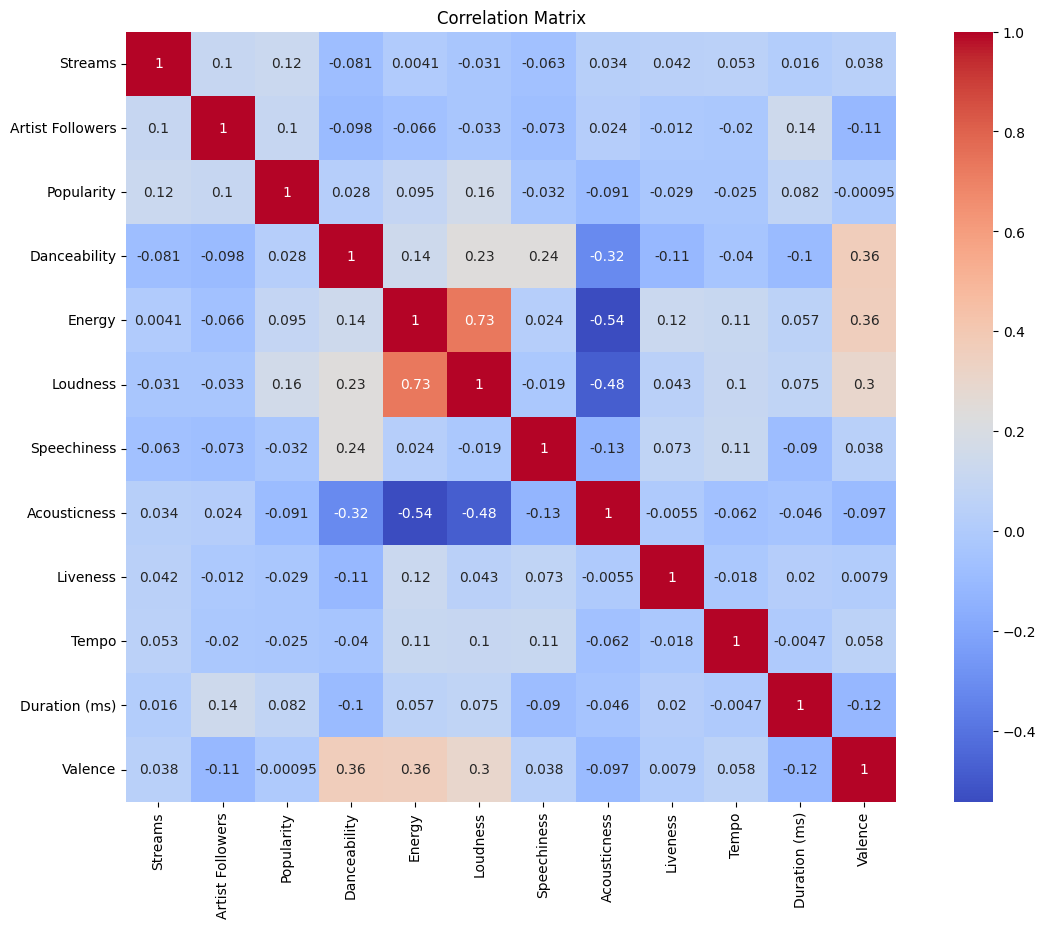

In [25]:
# Correlation matrix
correlation_matrix = spotify_clean.corr()
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
sns.pairplot(spotify_clean)
plt.show()

## Data Processing


####Decision Tree Regression


This section is under construction to loop through the columns and find the one that is best suited for a target. It needs some work to identify the best max depth for each target/column

In [ ]:
columns_to_iterate = spotify_clean.columns
columns_to_iterate

Index(['Streams', 'Artist Followers', 'Popularity', 'Danceability', 'Energy',
       'Loudness', 'Speechiness', 'Acousticness', 'Liveness', 'Tempo',
       'Duration (ms)', 'Valence'],
      dtype='object')

In [ ]:
#I still need to work on optimizing the max depth in this loop for each feature/column

rmse_dict = {}

for column in columns_to_iterate:
  X = spotify_clean.drop(column, axis = 1)
  y = spotify_clean[column]

  numLoops = 500

  rms_error = np.zeros(numLoops)

  for idx in range(0,numLoops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    model = DecisionTreeRegressor(max_depth=3)         # Arbitrarily choosing max_depth of 3
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

  rmse_each = rms_error.mean().round(2)
  rmse_dict[column] = rmse_each

#print(f"CV RMSE: {rms_error.mean().round(2)*1000}")
#print(f"CV RMSE: {rms_error.mean().round(2)}")





In [ ]:
rmse_dict

In [ ]:
s_stats = spotify_clean.describe().transpose()
s_stats

In [ ]:
rmse_dict

This is to see a percent difference although this is under construction to understand what the numbers mean.

In [ ]:
#some coding help from chatgpt results have to be looked into???
# Initialize dictionary to store percent errors
percent_error_dict = {}

# Iterate over the dictionary keys (column names)
for column in rmse_dict:
    # Extract the mean for the current column
    mean_value = s_stats.loc[column, 'mean']

    # Calculate the percent error
    cv_rmse = rmse_dict[column]
    percent_error = (cv_rmse / mean_value) * 100

    # Store the percent error in the dictionary
    percent_error_dict[column] = percent_error

    # Print the result
    #print(f"Mean of actual {column} values: {mean_value}")
    print(f"Percent Error for {column}: {percent_error:.2f}%")

# Print the dictionary of percent errors
print(percent_error_dict)

In [ ]:
X = spotify_clean.drop('Popularity', axis = 1)
y = spotify_clean['Popularity']

In [ ]:
numLoops = 500

rms_error = np.zeros(numLoops)


for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = DecisionTreeRegressor(max_depth=3)         #choosing max_depth of 3 verify the value used with tree depth code block below
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))



print(f"CV RMSE: {rms_error.mean().round(2)}")



This is how we choose the tree depth

In [ ]:
max_depths = [1,2,3,4,5,6,7,8,9,10]
rms_depth = np.zeros(len(max_depths))
std_depth = np.zeros(len(max_depths))

numLoops = 500

for n, depth in enumerate(max_depths):
  rms_error = np.zeros(numLoops)

  for idx in range(0,numLoops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

  rms_depth[n] = rms_error.mean()
  std_depth[n] = rms_error.std( ddof = 1 )

In [ ]:
pd.DataFrame( zip( max_depths, rms_depth, std_depth ) )

In [ ]:
# Decision Tree Plot result for visualizing depth at 3 where the RMSE hinges towards a higher RMSE
plt.figure(figsize = (8,5))
plt.plot(max_depths, rms_depth)
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.xlim(0, 10.5)
plt.grid()

Rerun with max depth to optimal where rms is lowest and std is lowest
max depth = 3

In [ ]:
# Re run with max depth = 3
numLoops = 500

rms_error = np.zeros( numLoops )

for idx in range( 0, numLoops ):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2 )
  model = DecisionTreeRegressor( max_depth= 3 )
  model.fit( X_train, y_train )
  y_pred = model.predict( X_test )
  rms_error[idx] = np.sqrt( mean_squared_error( y_test, y_pred ) )

print(f"CV RMSE: {rms_error.mean().round(2)}")

### Data Visualization


In [ ]:
# # Option 1
# display(
#   graphviz.Source(
#     tree.export_graphviz(
#       model,
#       feature_names = X.columns,
#       filled = True,
#     )
#   )
# )

In [ ]:
# Option 2
plt.figure(figsize=(30,15))
tree_plot = tree.plot_tree(
  model,
  feature_names = X.columns,
  filled=True,
)

###Random Forest

In [ ]:
X = spotify_clean.drop('Popularity', axis = 1)
y = spotify_clean['Popularity']

In [ ]:
# two parameters - n_estimators (number of trees), max_depth (number of splits)
numLoops = 500

mean_error = np.zeros(numLoops)

# np.random.seed(42)
for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2 )
  model = RandomForestRegressor( n_estimators = 10 ) #n_estimators is number of trees in forest. Note: you can also choose max_depth for RFs
  model.fit( X_train, y_train )
  y_pred = model.predict( X_test )
  mean_error[idx] = mean_squared_error( y_test, y_pred )

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')
#np.sqrt(mean_error)[:50]

####How do you choose number of trees?

In [ ]:
num_trees = range(10,60,10)
cv_loops = 100
rmse_results = np.zeros(len(num_trees))
std_results = np.zeros(len(num_trees))

for n, trees in enumerate(num_trees):
  rmse_cv = np.zeros(cv_loops)
  np.random.seed(42)
  for i in range(cv_loops):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)
    rfModel = RandomForestRegressor( n_estimators=trees )
    rfModel.fit(X_train, y_train)
    y_pred_rf = rfModel.predict(X_test)
    rmse_cv[i] = np.sqrt(mean_squared_error(y_test, y_pred_rf))

  print(trees,' trees finished.')
  rmse_results[n] = rmse_cv.mean()
  std_results[n] = rmse_cv.std()


In [ ]:
pickle.dump(rfModel, open('rfModel.p','wb'))

In [ ]:
plt.plot(num_trees, rmse_results)
plt.xlabel('Tree No.')
plt.ylabel('RMSE')
plt.grid()

In [ ]:
pd.DataFrame( zip( rmse_results, std_results, ) )

In [ ]:
# plt.errorbar(num_trees, rmse_results, yerr=(std_results*2,std_results*2))
plt.errorbar(num_trees, rmse_results, yerr=std_results)
plt.xlabel('Tree No.')
plt.ylabel('RMSE')
plt.ylim(0,5)
plt.xlim(0,55)
plt.grid()

In [ ]:
print(f'RMSE with 40 trees: {rmse_results[3]}')

In [ ]:
len(rfModel.estimators_)

####Second Run of Random Forest
I changed the n_estimators to reflect the number that we arrived with from plotting plt.plot(num_trees, rmse_results)

In [ ]:
# two parameters - n_estimators (number of trees), max_depth (number of splits)
numLoops = 500

mean_error = np.zeros(numLoops)

# np.random.seed(42)
for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2 )
  model = RandomForestRegressor( n_estimators = 40 ) #n_estimators is number of trees in forest. Note: you can also choose max_depth for RFs
  model.fit( X_train, y_train )
  y_pred = model.predict( X_test )
  mean_error[idx] = mean_squared_error( y_test, y_pred )

print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')
#np.sqrt(mean_error)[:50]

In [ ]:
# Display one tree from the random forest
display(
  graphviz.Source(
    tree.export_graphviz(
      rfModel.estimators_[0],
      feature_names = X.columns,
    )
  )
)

####Find Important Predictors

In [ ]:
importances = rfModel.feature_importances_
forest_importances = pd.Series( importances, index = X.columns )

plt.figure()
# forest_importances.plot.bar()
forest_importances.sort_values( ascending = False ).plot.bar()
plt.title("Feature importances")
plt.ylabel('Feature Importance Score') ;

We will try and run the features that have the most feature importance. I will try and use only from Artist Followers to Acoustincness and run only those in the model to see if the model improves.

In [ ]:
( forest_importances.sort_values( ascending = False ) * 100 ).cumsum()

###XGBoost


In [ ]:
X = spotify_clean.drop('Popularity', axis = 1)
y = spotify_clean['Popularity']

In [ ]:
numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)
  xgbr = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=0, seed = 10)
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)


print(f'RMSE: {np.sqrt(mse_xgb).mean()}')

####XGBoost with Parameters

Now we will see if we can improve performance by changing some parameters

In [ ]:
# Specify the parameters you want to try and their ranges.
param_test = {
 'max_depth'     : [ 3, 4, 5, 6, 7 ],
 'learning_rate' : [ 0.1, 0.2, 0.3, 0.4 ],
 'n_estimators'  : [ 20, 40, 60, 80, 100, 120, 140 ],
}

# Perform the grid search
gsearch = GridSearchCV(
    estimator = xgb.XGBRegressor( objective = 'reg:squarederror', seed = 10 ),
    param_grid = param_test,
    scoring = 'neg_mean_squared_error',
    cv = 5,
)

# Fit to training data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05, random_state = 42 )
model = gsearch.fit(X_train,y_train)

# See grid search results
print(model.best_params_)

Now we will fit our XGBoost model with the best parameters

In [ ]:
numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.15 )
  xgbr = xgb.XGBRegressor(
      objective ='reg:squarederror',
      verbosity=0,
      learning_rate = 0.1,
      max_depth = 3,
      n_estimators = 100,
      seed = 10,
  )
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)

print(f'RMSE: {np.sqrt(mse_xgb).mean()}')

Feature Importance

In [ ]:
feat_imp = pd.Series(xgbr.feature_importances_, index=X.columns)
plt.figure(figsize = (10,6))
# ax = sns.barplot(x = feat_imp.index, y = feat_imp.values)
ax = sns.barplot(x = feat_imp.index, y = feat_imp.sort_values( ascending = False ).values )
ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )
plt.xlabel('Feature')
plt.ylabel('Feature Importance Score') ;

In [ ]:
(feat_imp.sort_values( ascending = False )*100).cumsum()

## CONCLUSION
This notebook provides me a baseline with the target "Popularity". The Random Forest performs the best with the lowest RMSE of 10.301 at time of running. I will create another notebook to run with only the features that the random forest mentioned although I will only be keeping the features up to where their contributions plateau. Below is the list from the feature importance section and will be used on the next notebook:
Artist Followers, Streams, Loudness, Acousticness         

This will validate that the others not list had little contrubutions to the performae of the model. The third notebook, I will use the getdummies to encode "Chord" and I will use labelencoder for "Genre" then run that df through the model(s) to see if the models perform better.

####Results

This is for popularity as a target

- Decision Tree CV RMSSE:---10.73
- Random Forrest RMSE:-------10.301301957650313
- XGBoost RMSE:-------------------10.598976096381444

### Data Cleaning Function
UNDER CONSTRUCTION